### 분석에 필요한 패키지 Import

In [ ]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
# !pip install xgboost lightgbm catboost scikit-learn --quiet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [3]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [4]:
df.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  
0                          0           0  
1                          3           1  
2                          2           0  
3                          5           1  
4                          2           1

In [5]:
target = 'LeaveOrNot'

In [7]:
X = df.drop(target,axis=1) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [9]:
X.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  
0                          0  
1                          3  
2                          2  
3                          5  
4                          2

In [10]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [11]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [12]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [14]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [15]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [16]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



#### 2. 의사결정나무

In [17]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
y_tree_pred = tree.predict(X_test)

In [19]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8359106529209622
Report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.78      0.71      0.74       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



#### 3. SVM

In [20]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [21]:
y_svm_pred = svm.predict(X_test)

In [22]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8548109965635738
Report :
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       775
           1       0.91      0.63      0.74       389

    accuracy                           0.85      1164
   macro avg       0.87      0.80      0.82      1164
weighted avg       0.86      0.85      0.85      1164



#### 4. kNN

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [24]:
y_knn_pred = knn.predict(X_test)

In [25]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8298969072164949
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       775
           1       0.82      0.63      0.71       389

    accuracy                           0.83      1164
   macro avg       0.83      0.78      0.80      1164
weighted avg       0.83      0.83      0.82      1164



#### 네 가지 단일 모델의 결과 비교

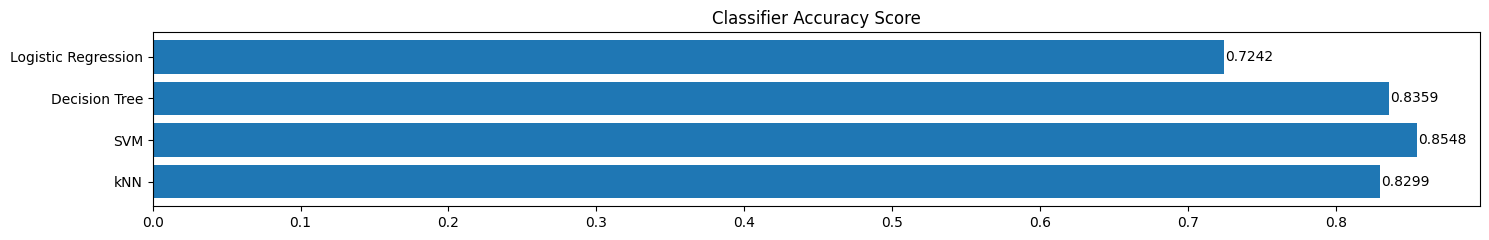

In [26]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [27]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [28]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8505


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [29]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8540


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [30]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8239


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [31]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [32]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8668


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [33]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train,y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8582


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [34]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train,y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8600


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [35]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator = LogisticRegression(random_state=SEED), # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8565


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

### 전처리
- 전처리는 동일하게 라벨인코딩을 진행했습니다 

In [36]:
df.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  
0                          0           0  
1                          3           1  
2                          2           0  
3                          5           1  
4                          2           1

In [ ]:
#종속변수는 EverBenched로 설정했습니다.
df['EverBenched'] = LabelEncoder().fit_transform(df['EverBenched'])
X = df.drop('EverBenched', axis=1)
y = df['EverBenched']

In [ ]:
cat_features = [X.columns.get_loc(c) for c in ['City', 'Education', 'Gender']]

### 모델링
- catboost,XGBoost,LGBM을 이용해서 모델링을 진행했습니다

In [72]:
cat_cols = [
    'Education',
    'City',
    'Gender',
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:

model = CatBoostClassifier(
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

model.fit(X_train,y_train)
cat_y_pred = model.predict(X_test)

In [77]:
print(f"Accuracy: {accuracy_score(y_test, cat_y_pred)}")

Accuracy: 0.8872180451127819


#### XGBoost 사용

In [79]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_acc = xgb_model.score(X_test, y_test)
print(f"XGBoost 정확도: {xgb_acc}")

XGBoost 정확도: 0.8764769065520945


### LightGBM 사용

In [81]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_acc = lgbm_model.score(X_test, y_test)
print(f"LightGBM 정확도: {lgbm_acc:}")

LightGBM 정확도: 0.8861439312567132


### 하이퍼파라미터튜닝
- 랜덤서치를 통해 하이퍼파라미터를 튜닝했습니다

In [62]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

In [ ]:

model = CatBoostClassifier(
    cat_features=cat_features,
    verbose=0,
    random_seed=42
)

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    random_state=42,
    error_score='raise'
)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000018EEE057FD0>,
                   n_iter=5,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8],
                                        'iterations': [100, 300, 500],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='accuracy')

In [ ]:
# 최적의 파라미터 리스트입니다
print("Best Parameters:", search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 4, 'border_count': 32}


In [63]:
# 최적의 파라미터로 예측을 해보겠습니다다
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       826
           1       0.00      0.00      0.00       105

    accuracy                           0.89       931
   macro avg       0.44      0.50      0.47       931
weighted avg       0.79      0.89      0.83       931



In [ ]:
# 정확도 출력쓰
cat_hyper_acc = best_model.score(X_test, y_test)
print(f"하이퍼파라미터튜닝한 catboosting: {cat_hyper_acc}")

하이퍼파라미터튜닝한 catboosting: 0.8872180451127819


## 결과 해석
- 세가지의 앙상블 기법을 사용했는데 catboosting이 88.72의 정확도로 가장 좋은 결과가 나왔다
- randomsearch를 통해 하이퍼파라미터 튜닝을 진행한 후 모델링도 진행해봤다. 
- 예전에 하이퍼파라미터에 대해 교육을 들었을 때 default값으로 있는 하이퍼파라미터가 가장 좋은 값으로 구성되어있다고 들었고 또한 실무에 계신 현업자분도 하이퍼파라미터튜닝은 결과를 거의 바꿀 수 없다고 했었다.
- 그래도 혹시나 하고 돌려봤지만 결과가 달라지지 않았다...
- 앙상블 교육세션 때 배운 블랙박스 문제에 대해 다시 한번 느꼈다.